## Model Training

#### 1.1 Import Data and Required Packages
##### Importing Pandas, Numpy, Matplotlib, Seaborn and Warings Library.

In [19]:
# Basic Import
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns
# Modelling
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor,AdaBoostRegressor
from sklearn.svm import SVR
from sklearn.linear_model import LinearRegression, Ridge,Lasso
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.model_selection import RandomizedSearchCV
from catboost import CatBoostRegressor
from xgboost import XGBRegressor
import warnings

#### Import the CSV Data as Pandas DataFrame

In [17]:
df=pd.read_csv('data/retail_store_inventory.csv')

#### Show Top 5 Records

In [4]:
df.head()

,Date,Store ID,Product ID,Category,Region,Inventory Level,Units Sold,Units Ordered,Demand Forecast,Price,Discount,Weather Condition,Holiday/Promotion,Competitor Pricing,Seasonality
0,2022-01-01,S001,P0001,Groceries,North,231,127,55,135.47,33.50,20,Rainy,0,29.69,Autumn
1,2022-01-01,S001,P0002,Toys,South,204,150,66,144.04,63.01,20,Sunny,0,66.16,Autumn
2,2022-01-01,S001,P0003,Toys,West,102,65,51,74.02,27.99,10,Sunny,1,31.32,Summer
3,2022-01-01,S001,P0004,Toys,North,469,61,164,62.18,32.72,10,Cloudy,1,34.74,Autumn
4,2022-01-01,S001,P0005,Electronics,East,166,14,135,9.26,73.64,0,Sunny,0,68.95,Summer


In [45]:
# Ensure a Date column exists; if not, create a synthetic daily date range
if 'Date' in df.columns:
	# try to convert existing column to datetime, coerce errors to NaT
	df['Date'] = pd.to_datetime(df['Date'], errors='coerce')
	# if conversion produced NaT values, fill them with a generated date range
	if df['Date'].isna().any():
		dates = pd.date_range(start='2020-01-01', periods=len(df), freq='D')
		df['Date'] = df['Date'].fillna(pd.Series(dates, index=df.index))
else:
	df['Date'] = pd.date_range(start='2020-01-01', periods=len(df), freq='D')

df['year'] = df['Date'].dt.year
df['prev_demand'] = df['Demand Forecast'].shift(1)
df.dropna(inplace=True)


#### Preparing X and Y variables

In [50]:

X = df.drop(columns=['Demand Forecast', 'Date', 'Product ID', 'Store ID'])
y = df['Demand Forecast']


In [51]:
X.head()

,Category,Region,Inventory Level,Units Sold,Units Ordered,Price,Discount,Weather Condition,Holiday/Promotion,Competitor Pricing,Seasonality,year,prev_demand
1,Toys,South,204,150,66,63.01,20,Sunny,0,66.16,Autumn,2020,135.47
2,Toys,West,102,65,51,27.99,10,Sunny,1,31.32,Summer,2020,144.04
3,Toys,North,469,61,164,32.72,10,Cloudy,1,34.74,Autumn,2020,74.02
4,Electronics,East,166,14,135,73.64,0,Sunny,0,68.95,Summer,2020,62.18
5,Groceries,South,138,128,102,76.83,10,Sunny,1,79.35,Winter,2020,9.26


In [52]:
y = df['Demand Forecast']

In [ ]:
##pd.DataFrame(X.toarray()).head()

In [21]:
y

0        135.47
1        144.04
2         74.02
3         62.18
4          9.26
          ...  
73095     18.46
73096     48.43
73097     39.65
73098    270.52
73099      2.33
Name: Demand Forecast, Length: 73100, dtype: float64

In [ ]:
# Create Column Transformer with 3 types of transformers
num_features = X.select_dtypes(exclude="object").columns
cat_features = X.select_dtypes(include="object").columns

from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer

numeric_transformer = StandardScaler()
oh_transformer = OneHotEncoder()

preprocessor = ColumnTransformer(
    [
        ("OneHotEncoder", oh_transformer, cat_features),
         ("StandardScaler", numeric_transformer, num_features),        
    ]
)

In [54]:
X = preprocessor.fit_transform(X)

In [56]:
X.shape

(73099, 26)

In [57]:
# separate dataset into train and test
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=42)
X_train.shape, X_test.shape

((58479, 26), (14620, 26))

#### Create an Evaluate Function to give all metrics after model Training

In [58]:
def evaluate_model(true, predicted):
    mae = mean_absolute_error(true, predicted)
    mse = mean_squared_error(true, predicted)
    rmse = np.sqrt(mean_squared_error(true, predicted))
    r2_square = r2_score(true, predicted)
    return mae, rmse, r2_square

In [80]:
models = {
    "Linear Regression": LinearRegression(),
    "Lasso": Lasso(),
    "Ridge": Ridge(),
    "K-Neighbors Regressor": KNeighborsRegressor(),
    "Decision Tree": DecisionTreeRegressor(),
    "Random Forest Regressor": RandomForestRegressor(),

}
model_list = []
r2_list =[]

for i in range(len(list(models))):
    model = list(models.values())[i]
    model.fit(X_train, y_train) # Train model

    # Make predictions
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    
    # Evaluate Train and Test dataset
    model_train_mae , model_train_rmse, model_train_r2 = evaluate_model(y_train, y_train_pred)

    model_test_mae , model_test_rmse, model_test_r2 = evaluate_model(y_test, y_test_pred)

    
    print(list(models.keys())[i])
    model_list.append(list(models.keys())[i])
    
    print('Model performance for Training set')
    print("- Root Mean Squared Error: {:.4f}".format(model_train_rmse))
    print("- Mean Absolute Error: {:.4f}".format(model_train_mae))
    print("- R2 Score: {:.4f}".format(model_train_r2))

    print('----------------------------------')
    
    print('Model performance for Test set')
    print("- Root Mean Squared Error: {:.4f}".format(model_test_rmse))
    print("- Mean Absolute Error: {:.4f}".format(model_test_mae))
    print("- R2 Score: {:.4f}".format(model_test_r2))
    r2_list.append(model_test_r2)
    
    print('='*35)
    print('\n')

Linear Regression
Model performance for Training set
- Root Mean Squared Error: 8.6543
- Mean Absolute Error: 7.4888
- R2 Score: 0.9937
----------------------------------
Model performance for Test set
- Root Mean Squared Error: 8.6830
- Mean Absolute Error: 7.5229
- R2 Score: 0.9937


Lasso
Model performance for Training set
- Root Mean Squared Error: 8.7136
- Mean Absolute Error: 7.5228
- R2 Score: 0.9936
----------------------------------
Model performance for Test set
- Root Mean Squared Error: 8.7469
- Mean Absolute Error: 7.5643
- R2 Score: 0.9936


Ridge
Model performance for Training set
- Root Mean Squared Error: 8.6542
- Mean Absolute Error: 7.4887
- R2 Score: 0.9937
----------------------------------
Model performance for Test set
- Root Mean Squared Error: 8.6828
- Mean Absolute Error: 7.5227
- R2 Score: 0.9937


K-Neighbors Regressor
Model performance for Training set
- Root Mean Squared Error: 28.3465
- Mean Absolute Error: 22.7870
- R2 Score: 0.9326
---------------------

### Results

In [79]:
pd.DataFrame(list(zip(model_list, r2_list)), columns=['Model Name', 'R2_Score']).sort_values(by=["R2_Score"],ascending=False)

,Model Name,R2_Score
2,Ridge,0.993712
0,Linear Regression,0.993712
1,Lasso,0.993619
4,Decision Tree,0.987358
3,K-Neighbors Regressor,0.903203


## Linear Regression

In [62]:
lin_model = LinearRegression(fit_intercept=True)
lin_model = lin_model.fit(X_train, y_train)
y_pred = lin_model.predict(X_test)
score = r2_score(y_test, y_pred)*100
print(" Accuracy of the model is %.2f" %score)

 Accuracy of the model is 99.37


## Plot y_pred and y_test

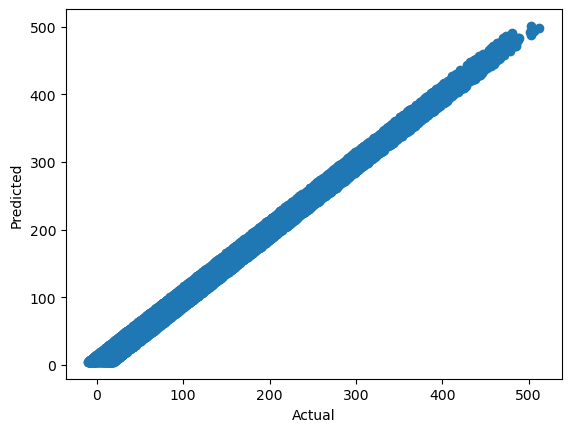

In [63]:
plt.scatter(y_test,y_pred);
plt.xlabel('Actual');
plt.ylabel('Predicted');

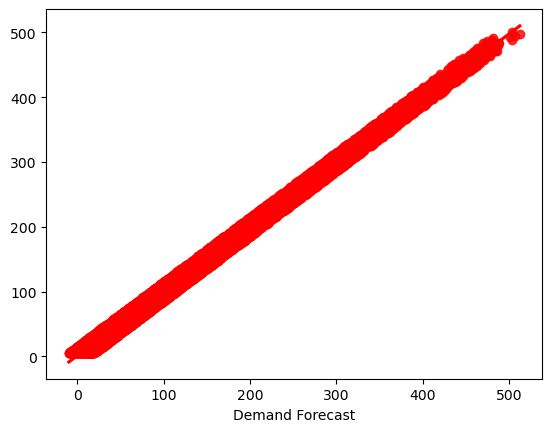

In [64]:
sns.regplot(x=y_test,y=y_pred,ci=None,color ='red');

#### Difference between Actual and Predicted Values

In [65]:
pred_df=pd.DataFrame({'Actual Value':y_test,'Predicted Value':y_pred,'Difference':y_test-y_pred})
pred_df

,Actual Value,Predicted Value,Difference
27481,136.14,141.134766,-4.994766
6197,49.59,49.323242,0.266758
33346,235.11,225.227539,9.882461
41936,93.83,84.945312,8.884687
21561,185.76,194.131836,-8.371836
...,...,...,...
24039,44.07,40.890625,3.179375
21429,41.85,54.226562,-12.376562
39931,130.56,117.817383,12.742617
12935,196.75,201.235352,-4.485352


Units Sold            0.996853
Inventory Level       0.588561
prev_demand           0.004149
Discount              0.002339
Competitor Pricing    0.000843
Price                 0.000675
Holiday/Promotion    -0.000527
Units Ordered        -0.001102
year                 -0.002122
Name: Demand Forecast, dtype: float64


C:\Users\adarsh kumar\AppData\Local\Temp\ipykernel_7532\466095360.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=target_corr.values, y=target_corr.index, palette='coolwarm')


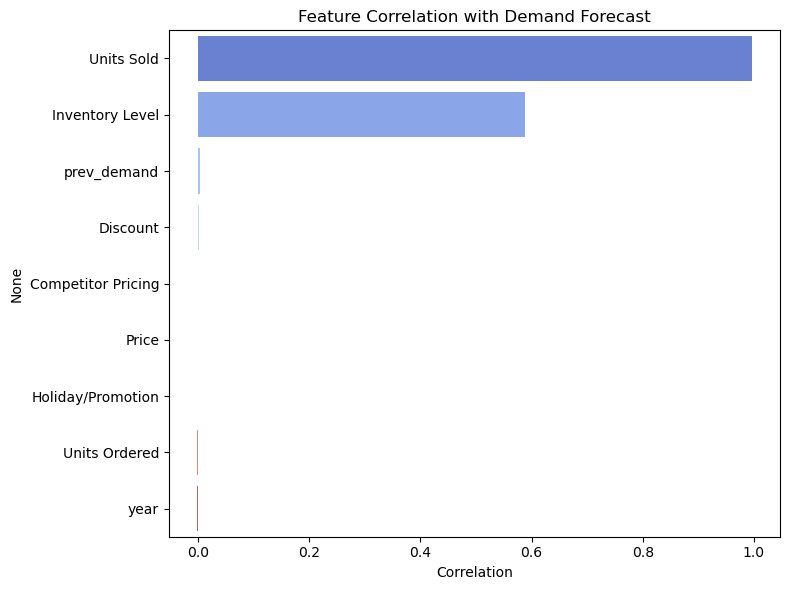

In [74]:
# Compute correlation between numeric features and the target using the dataframe
# num_features is an Index of column names defined earlier
corr = df[num_features.tolist() + ['Demand Forecast']].corr()

# Display correlation with target (exclude the target itself)
target_corr = corr['Demand Forecast'].drop('Demand Forecast').sort_values(ascending=False)
print(target_corr)

# Visualize top correlated features
plt.figure(figsize=(8,6))
sns.barplot(x=target_corr.values, y=target_corr.index, palette='coolwarm')
plt.title('Feature Correlation with Demand Forecast')
plt.xlabel('Correlation')
plt.tight_layout()
plt.show()

In [77]:
from sklearn.ensemble import RandomForestRegressor

# Train model
X = df.drop(columns=['Demand Forecast'])
y = df['Demand Forecast']

rf = RandomForestRegressor(random_state=42)
rf.fit(X, y)

# Get feature importance
importance = pd.Series(rf.feature_importances_, index=X.columns).sort_values(ascending=False)
print(importance)

# Plot
plt.figure(figsize=(8,6))
sns.barplot(x=importance.values, y=importance.index, palette='viridis')
plt.title('Feature Importance (Random Forest)')
plt.show()
# Show top features and cumulative importance
top_n = 10
top_features = importance.head(top_n)
print(f"Top {top_n} features:\n", top_features)

plt.figure(figsize=(8,6))
sns.barplot(x=top_features.values, y=top_features.index, palette='viridis')
plt.title(f'Top {top_n} Feature Importances (Random Forest)')
for i, v in enumerate(top_features.values):
    plt.text(v + top_features.values.max()*0.01, i, f"{v:.3f}", va='center')
plt.tight_layout()
plt.show()

# Cumulative importance plot
cum_importance = importance.cumsum()
plt.figure(figsize=(10,4))
plt.plot(cum_importance.values, marker='o')
plt.xticks(range(len(cum_importance)), cum_importance.index, rotation=90)
plt.ylabel('Cumulative Importance')
plt.title('Cumulative Feature Importance')
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

ValueError: could not convert string to float: 'S001'